# Capstone Project Notebook: New York County State Types and Physical Inactivity Levels
By Renata Bastos Gottgtroy

## Steps:
1. Import libraries needed
2. Physical inactivity data preparation
 - Read Physical Inactivity file
 - Clean Physical Inactvity Dataframe
 - Download coordinates of each County and append to Physical Inactivity dataframe
 - Visualize Counties in the New York State
3. Venue data preparation
 - Define Foursquare credentials
 - Create a function and call it to retrieve venues per county with their category type
 - Explore Foursquare data
 - One hot encoding
 - Create a dataframe with the 10 most common venues in each county
4. Feature reduction by clustering Counties 
 - Find best K for Kmeans clustering
 - Run Kmeans clustering
 - Create a dataframe with venue data, physical inactivity data and cluster labels
 - Visualize clusters
5. Predict physical inactivty based on County clusters
 - Convert target variable from object to float
 - Create four categories of physical inactivity and add to combined dataframe
 - Define feature set and target variable
 - Split data into train and test sets
 - Train 2 classification models with training data
 - Evaluate models using test set

### 1. Import libraries needed

In [1]:
import pandas as pd
import numpy as np

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

!pip install opencage
from opencage.geocoder import OpenCageGeocode
from pprint import pprint

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


### 2. Physical inactivity data preparation

#### Read Physical Inactivity file

In [2]:
pa_df = pd.read_csv (r'C:\Users\renat\OneDrive - AUT University\Data Science Courses\IBM Data Science Course\Course 9 Capstone project\physical activity by ny county.csv')
pa_df.head()

NY County Physical Inactivity Confidence interval       County      Rank
0       Albany              20.40%    42.6016 -73.9727       Albany   Rank: 8
1     Allegany              20.20%      42.26 -78.0476     Allegany   Rank: 6
2        Bronx              31.10%    40.8517 -73.8632        Bronx  Rank: 62
3       Broome              26.00%    42.2073 -75.9218       Broome  Rank: 51
4  Cattaraugus              26.30%    42.2486 -78.6784  Cattaraugus  Rank: 53

In [3]:
pa_df.shape

(62, 5)

#### Clean Physical Inactivity Dataframe

Drop columns that are not needed

In [4]:
pa_df.drop(pa_df.columns[2:], axis=1, inplace=True)
pa_df.head()


NY County Physical Inactivity
0       Albany              20.40%
1     Allegany              20.20%
2        Bronx              31.10%
3       Broome              26.00%
4  Cattaraugus              26.30%

In [5]:
pa_df.shape

(62, 2)

#### Download coordinates of each County and append to Physical Inactivity dataframe

Define Open Cage credentials

In [6]:
key = '75070d445b434a84a86774e9f7942e73'
geocoder = OpenCageGeocode(key)

Download latitiude and longitude values of each county and add as columns to dataframe

In [111]:
list_lat = []   # create empty lists
list_long = []

for index, row in pa_df.iterrows(): # iterate over rows in dataframe
    County = row['NY County']     
    query = str(County)+', NY'

    results = geocoder.geocode(query)   
    lat = results[0]['geometry']['lat']
    long = results[0]['geometry']['lng']

    list_lat.append(lat)
    list_long.append(long)

# create new columns from lists    

pa_df['Latitude'] = list_lat   
pa_df['Longitude'] = list_long

In [8]:
pa_df.head()

NY County Physical Inactivity   Latitude  Longitude
0       Albany              20.40%  42.651167 -73.754968
1     Allegany              20.20%  42.244606 -78.041928
2        Bronx              31.10%  40.850485 -73.840404
3       Broome              26.00%  42.145562 -75.840411
4  Cattaraugus              26.30%  42.223482 -78.647710

#### Visualize Counties in the New York State

In [114]:
map_ny_state = folium.Map(location=[43.00035, -75.4999], zoom_start=7)

# add markers to map
for lat, lng, ny_county in zip(pa_df['Latitude'], pa_df['Longitude'], pa_df['NY County']):
    label = '{}'.format(ny_county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny_state)  
    
map_ny_state

### 3. Venue data preparation

#### Define Foursquare credentials

In [10]:
CLIENT_ID = 'KLQ3QKOXT34YAZOCUGPDS4EN0XDZJI5J0QDVM2HXKSKPFW1Z' # your Foursquare ID
CLIENT_SECRET = 'HBOI4VNNCH1PQ01HRFPF33OFJEPJX22YYWOHHJ54IZMIIALH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KLQ3QKOXT34YAZOCUGPDS4EN0XDZJI5J0QDVM2HXKSKPFW1Z
CLIENT_SECRET:HBOI4VNNCH1PQ01HRFPF33OFJEPJX22YYWOHHJ54IZMIIALH


#### Create a function and call it to retrieve venues per county with their category type

In [11]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['NY County', 
                  'County Latitude', 
                  'County Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Call function

In [14]:
# type your answer here

ny_venues = getNearbyVenues(names=pa_df['NY County'],
                                   latitudes=pa_df['Latitude'],
                                   longitudes=pa_df['Longitude']
                                  )

Albany
Allegany
Bronx
Broome
Cattaraugus
Cayuga
Chautauqua
Chemung
Chenango
Clinton
Columbia
Cortland
Delaware
Dutchess
Erie
Essex
Franklin
Fulton
Genesee
Greene
Hamilton
Herkimer
Jefferson
Kings
Lewis
Livingston
Madison
Monroe
Montgomery
Nassau
New York
Niagara
Oneida
Onondaga
Ontario
Orange
Orleans
Oswego
Otsego
Putnam
Queens
Rensselaer
Richmond
Rockland
Saratoga
Schenectady
Schoharie
Schuyler
Seneca
St. Lawrence
Steuben
Suffolk
Sullivan
Tioga
Tompkins
Ulster
Warren
Washington
Wayne
Westchester
Wyoming
Yates


In [15]:
print(ny_venues.shape)
ny_venues.head()

(3440, 7)


NY County  County Latitude  County Longitude  \
0    Albany        42.651167        -73.754968   
1    Albany        42.651167        -73.754968   
2    Albany        42.651167        -73.754968   
3    Albany        42.651167        -73.754968   
4    Albany        42.651167        -73.754968   

                            Venue  Venue Latitude  Venue Longitude  \
0        Renaissance Albany Hotel       42.650625       -73.755687   
1                  City Beer Hall       42.649660       -73.754787   
2              Cider Belly Donuts       42.650487       -73.752350   
3        dp An American Brasserie       42.653154       -73.751502   
4  Stacks Espresso Bar - Downtown       42.650257       -73.750645   

        Venue Category  
0                Hotel  
1                  Pub  
2                 Café  
3  American Restaurant  
4                 Café

#### Explore Foursquare data

How many venues were returned for each County

In [16]:
ny_venues.groupby('NY County').count()

County Latitude  County Longitude  Venue  Venue Latitude  \
NY County                                                               
Albany                   100               100    100             100   
Allegany                  12                12     12              12   
Bronx                    100               100    100             100   
Broome                   100               100    100             100   
Cattaraugus               41                41     41              41   
...                      ...               ...    ...             ...   
Washington                 6                 6      6               6   
Wayne                     23                23     23              23   
Westchester              100               100    100             100   
Wyoming                   16                16     16              16   
Yates                     52                52     52              52   

             Venue Longitude  Venue Category  
NY County                                     
Albany                   100             100  
Allegany                  12              12  
Bronx                    100             100  
Broome                   100             100  
Cattaraugus               41              41  
...                      ...             ...  
Washington                 6               6  
Wayne                     23              23  
Westchester              100             100  
Wyoming                   16              16  
Yates                     52              52  

[62 rows x 6 columns]

How many unique categories

In [17]:
print('There are {} uniques categories.'.format(len(ny_venues['Venue Category'].unique())))

There are 315 uniques categories.


#### One hot encoding

In [18]:
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

# add County column back to dataframe
ny_onehot['NY County'] = ny_venues['NY County'] 

# move County column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

print(ny_onehot.shape)
ny_onehot.head()

(3440, 316)


NY County  Accessories Store  Afghan Restaurant  African Restaurant  \
0    Albany                  0                  0                   0   
1    Albany                  0                  0                   0   
2    Albany                  0                  0                   0   
3    Albany                  0                  0                   0   
4    Albany                  0                  0                   0   

   Airport  Airport Service  Alternative Healer  American Restaurant  \
0        0                0                   0                    0   
1        0                0                   0                    0   
2        0                0                   0                    0   
3        0                0                   0                    1   
4        0                0                   0                    0   

   Antique Shop  Arepa Restaurant  ...  Water Park  Waterfall  \
0             0                 0  ...           0          0   
1             0                 0  ...           0          0   
2             0                 0  ...           0          0   
3             0                 0  ...           0          0   
4             0                 0  ...           0          0   

   Weight Loss Center  Wine Bar  Wine Shop  Winery  Wings Joint  \
0                   0         0          0       0            0   
1                   0         0          0       0            0   
2                   0         0          0       0            0   
3                   0         0          0       0            0   
4                   0         0          0       0            0   

   Women's Store  Yoga Studio  Zoo  
0              0            0    0  
1              0            0    0  
2              0            0    0  
3              0            0    0  
4              0            0    0  

[5 rows x 316 columns]

#### Create a dataframe with the 10 most common venues in each county

Group rows by County and by taking the mean of the frequency of occurrence of each category

In [19]:
ny_grouped = ny_onehot.groupby('NY County').mean().reset_index()
print(ny_grouped.shape)
ny_grouped

(62, 316)


NY County  Accessories Store  Afghan Restaurant  African Restaurant  \
0        Albany            0.00000                0.0                0.00   
1      Allegany            0.00000                0.0                0.00   
2         Bronx            0.00000                0.0                0.00   
3        Broome            0.00000                0.0                0.00   
4   Cattaraugus            0.02439                0.0                0.00   
..          ...                ...                ...                 ...   
57   Washington            0.00000                0.0                0.00   
58        Wayne            0.00000                0.0                0.00   
59  Westchester            0.00000                0.0                0.01   
60      Wyoming            0.00000                0.0                0.00   
61        Yates            0.00000                0.0                0.00   

    Airport  Airport Service  Alternative Healer  American Restaurant  \
0       0.0              0.0                 0.0             0.040000   
1       0.0              0.0                 0.0             0.000000   
2       0.0              0.0                 0.0             0.010000   
3       0.0              0.0                 0.0             0.040000   
4       0.0              0.0                 0.0             0.146341   
..      ...              ...                 ...                  ...   
57      0.0              0.0                 0.0             0.000000   
58      0.0              0.0                 0.0             0.043478   
59      0.0              0.0                 0.0             0.110000   
60      0.0              0.0                 0.0             0.125000   
61      0.0              0.0                 0.0             0.038462   

    Antique Shop  Arepa Restaurant  ...  Water Park  Waterfall  \
0        0.01000              0.00  ...         0.0        0.0   
1        0.00000              0.00  ...         0.0        0.0   
2        0.00000              0.01  ...         0.0        0.0   
3        0.00000              0.00  ...         0.0        0.0   
4        0.02439              0.00  ...         0.0        0.0   
..           ...               ...  ...         ...        ...   
57       0.00000              0.00  ...         0.0        0.0   
58       0.00000              0.00  ...         0.0        0.0   
59       0.00000              0.00  ...         0.0        0.0   
60       0.00000              0.00  ...         0.0        0.0   
61       0.00000              0.00  ...         0.0        0.0   

    Weight Loss Center  Wine Bar  Wine Shop    Winery  Wings Joint  \
0                  0.0      0.01       0.01  0.000000      0.00000   
1                  0.0      0.00       0.00  0.000000      0.00000   
2                  0.0      0.00       0.00  0.000000      0.00000   
3                  0.0      0.01       0.00  0.000000      0.00000   
4                  0.0      0.00       0.00  0.000000      0.02439   
..                 ...       ...        ...       ...          ...   
57                 0.0      0.00       0.00  0.000000      0.00000   
58                 0.0      0.00       0.00  0.000000      0.00000   
59                 0.0      0.01       0.00  0.000000      0.00000   
60                 0.0      0.00       0.00  0.000000      0.00000   
61                 0.0      0.00       0.00  0.019231      0.00000   

    Women's Store  Yoga Studio  Zoo  
0         0.00000          0.0  0.0  
1         0.00000          0.0  0.0  
2         0.00000          0.0  0.0  
3         0.00000          0.0  0.0  
4         0.02439          0.0  0.0  
..            ...          ...  ...  
57        0.00000          0.0  0.0  
58        0.00000          0.0  0.0  
59        0.00000          0.0  0.0  
60        0.00000          0.0  0.0  
61        0.00000          0.0  0.0  

[62 rows x 316 columns]

Define function to sort venues in descending order

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
#Create dataframe displaying the top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['NY County']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
county_venues_sorted = pd.DataFrame(columns=columns)
county_venues_sorted['NY County'] = ny_grouped['NY County']

for ind in np.arange(ny_grouped.shape[0]):
    county_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

print(county_venues_sorted.shape)
county_venues_sorted.head()

(62, 11)


NY County 1st Most Common Venue 2nd Most Common Venue  \
0       Albany                   Pub                  Café   
1     Allegany              Pharmacy                  Café   
2        Bronx    Italian Restaurant           Pizza Place   
3       Broome        Sandwich Place                 Diner   
4  Cattaraugus   American Restaurant             Ski Lodge   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0              Pharmacy           Coffee Shop               Theater   
1           Post Office            Playground         Grocery Store   
2                   Gym           Coffee Shop            Donut Shop   
3           Pizza Place    Italian Restaurant         Grocery Store   
4              Ski Area            Ski Chalet                   Bar   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0   American Restaurant                  Park     Convenience Store   
1        Discount Store        Nightlife Spot                Bakery   
2                Bakery                 Diner        Sandwich Place   
3                   Bar              Pharmacy   American Restaurant   
4        Discount Store            Steakhouse                 Hotel   

  9th Most Common Venue   10th Most Common Venue  
0                 Hotel  New American Restaurant  
1                  Food     Fast Food Restaurant  
2           Supermarket            Deli / Bodega  
3               Brewery              Coffee Shop  
4               Brewery        Accessories Store

### 4. Feature reduction by clustering Counties 

#### Find best K for Kmeans clustering

Find the best k to use by finding the elbow point using the training set

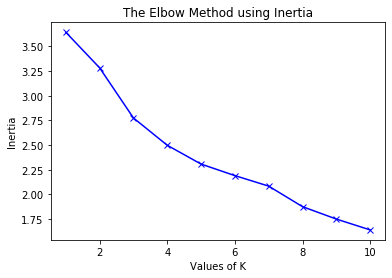

In [28]:
from sklearn import metrics 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

ny_clustering = ny_grouped.drop(columns =['NY County'])
inertia=[]
mapping={}
K = range(1,11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(ny_clustering)
    
    inertia.append(kmeans.inertia_)
    
    mapping[k] = kmeans.inertia_ 
    
plt.plot(K, inertia, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

Find the best k to use by finding the "global maximum" of the silhouette score 

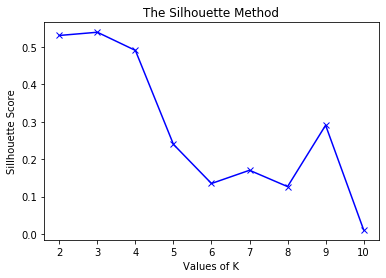

In [29]:
from sklearn.metrics import silhouette_score

sil = []
ksil = range(2,11) # min of 2 clusters to be able to calculate silhouette score

for k in ksil:
    kmeans_sil = KMeans(n_clusters = k, random_state=0).fit(ny_clustering)
    labels = kmeans_sil.labels_
    sil.append(silhouette_score(ny_clustering, labels, metric = 'euclidean'))
    
plt.plot(ksil, sil, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Sillhouette Score') 
plt.title('The Silhouette Method') 
plt.show() 

#### Run K-means to cluster the Counties into 3 clusters

In [30]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### Create a dataframe with venue data, physical inactivity data and cluster labels

In [32]:
# add clustering labels
train_feature_df_clustered = county_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ny_merged = pa_df

# merge to_grouped with to_data to add latitude/longitude for each neighborhood
ny_merged = ny_merged.join(county_venues_sorted.set_index('NY County'), on='NY County', how = 'right') 

ny_merged

NY County Physical Inactivity   Latitude  Longitude  Cluster Labels  \
0        Albany              20.40%  42.651167 -73.754968               0   
1      Allegany              20.20%  42.244606 -78.041928               0   
2         Bronx              31.10%  40.850485 -73.840404               0   
3        Broome              26.00%  42.145562 -75.840411               0   
4   Cattaraugus              26.30%  42.223482 -78.647710               0   
..          ...                 ...        ...        ...             ...   
57   Washington              22.70%  43.229454 -73.447134               0   
58        Wayne              26.40%  43.150056 -77.037760               0   
59  Westchester              19.20%  41.176314 -73.790755               0   
60      Wyoming              23.00%  42.703981 -78.241523               0   
61        Yates              26.80%  42.644444 -77.112177               0   

   1st Most Common Venue       2nd Most Common Venue 3rd Most Common Venue  \
0                    Pub                        Café              Pharmacy   
1               Pharmacy                        Café           Post Office   
2     Italian Restaurant                 Pizza Place                   Gym   
3         Sandwich Place                       Diner           Pizza Place   
4    American Restaurant                   Ski Lodge              Ski Area   
..                   ...                         ...                   ...   
57      Recording Studio              Ice Cream Shop           Cheese Shop   
58        Discount Store  Construction & Landscaping        Sandwich Place   
59   American Restaurant                 Pizza Place    Italian Restaurant   
60     Convenience Store              Ice Cream Shop   American Restaurant   
61              Pharmacy                       Hotel        Discount Store   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0            Coffee Shop               Theater   American Restaurant   
1             Playground         Grocery Store        Discount Store   
2            Coffee Shop            Donut Shop                Bakery   
3     Italian Restaurant         Grocery Store                   Bar   
4             Ski Chalet                   Bar        Discount Store   
..                   ...                   ...                   ...   
57         Go Kart Track                  Lake     Convenience Store   
58         Grocery Store            Hobby Shop      Business Service   
59           Coffee Shop                  Café         Deli / Bodega   
60            Campground            Restaurant                 Hotel   
61                  Café           Pizza Place   American Restaurant   

         7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                         Park     Convenience Store                 Hotel   
1               Nightlife Spot                Bakery                  Food   
2                        Diner        Sandwich Place           Supermarket   
3                     Pharmacy   American Restaurant               Brewery   
4                   Steakhouse                 Hotel               Brewery   
..                         ...                   ...                   ...   
57               Historic Site             Drugstore     Electronics Store   
58                        Café             Ski Trail    Mexican Restaurant   
59              Ice Cream Shop                 Trail    Mexican Restaurant   
60  Construction & Landscaping           Post Office       Motorcycle Shop   
61                  Restaurant           Supermarket        Sandwich Place   

     10th Most Common Venue  
0   New American Restaurant  
1      Fast Food Restaurant  
2             Deli / Bodega  
3               Coffee Shop  
4         Accessories Store  
..                      ...  
57      Empanada Restaurant  
58             Liquor Store  
59               Restaurant  
60              Gas Station  
61          

Count the number of Counties in each cluster

In [115]:
ny_merged.groupby('Cluster Labels').count()

NY County  Physical Inactivity  Latitude  Longitude  \
Cluster Labels                                                        
0                      60                   60        60         60   
1                       1                    1         1          1   
2                       1                    1         1          1   

                1st Most Common Venue  2nd Most Common Venue  \
Cluster Labels                                                 
0                                  60                     60   
1                                   1                      1   
2                                   1                      1   

                3rd Most Common Venue  4th Most Common Venue  \
Cluster Labels                                                 
0                                  60                     60   
1                                   1                      1   
2                                   1                      1   

                5th Most Common Venue  6th Most Common Venue  \
Cluster Labels                                                 
0                                  60                     60   
1                                   1                      1   
2                                   1                      1   

                7th Most Common Venue  8th Most Common Venue  \
Cluster Labels                                                 
0                                  60                     60   
1                                   1                      1   
2                                   1                      1   

                9th Most Common Venue  10th Most Common Venue  \
Cluster Labels                                                  
0                                  60                      60   
1                                   1                       1   
2                                   1                       1   

                Physical Inactivity Level  
Cluster Labels                             
0                                      60  
1                                       1  
2                                       1

#### Visualize clusters

In [112]:
# create map
map_clusters = folium.Map(location=[43.00035, -75.4999], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, county, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['NY County'], ny_merged['Cluster Labels']):
    label = folium.Popup(str(county) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 5. Predict physical inactivty based on County clusters

#### Convert target variable into float

In [41]:
print (ny_merged.dtypes)

NY County                  object
Physical Inactivity        object
Latitude                  float64
Longitude                 float64
Cluster Labels              int32
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object


In [42]:
ny_merged['Physical Inactivity'] = ny_merged['Physical Inactivity'].str.replace('%','').astype(np.float64)
ny_merged.dtypes

NY County                  object
Physical Inactivity       float64
Latitude                  float64
Longitude                 float64
Cluster Labels              int32
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

#### Create four categories of physical inactivity and add to combined dataframe

Use qcut to create categorical representations of physical inactivity based on quartiles

In [110]:
ny_merged['Physical Inactivity Level'] = pd.qcut(ny_merged['Physical Inactivity'], 4, labels = ['Least Active', 'Somewhat inactive', 'Somewhat Active', 'Most Active'])
ny_merged.head()

NY County  Physical Inactivity   Latitude  Longitude  Cluster Labels  \
0       Albany                 20.4  42.651167 -73.754968               0   
1     Allegany                 20.2  42.244606 -78.041928               0   
2        Bronx                 31.1  40.850485 -73.840404               0   
3       Broome                 26.0  42.145562 -75.840411               0   
4  Cattaraugus                 26.3  42.223482 -78.647710               0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                   Pub                  Café              Pharmacy   
1              Pharmacy                  Café           Post Office   
2    Italian Restaurant           Pizza Place                   Gym   
3        Sandwich Place                 Diner           Pizza Place   
4   American Restaurant             Ski Lodge              Ski Area   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0           Coffee Shop               Theater   American Restaurant   
1            Playground         Grocery Store        Discount Store   
2           Coffee Shop            Donut Shop                Bakery   
3    Italian Restaurant         Grocery Store                   Bar   
4            Ski Chalet                   Bar        Discount Store   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                  Park     Convenience Store                 Hotel   
1        Nightlife Spot                Bakery                  Food   
2                 Diner        Sandwich Place           Supermarket   
3              Pharmacy   American Restaurant               Brewery   
4            Steakhouse                 Hotel               Brewery   

    10th Most Common Venue Physical Inactivity Level  
0  New American Restaurant              Least Active  
1     Fast Food Restaurant              Least Active  
2            Deli / Bodega               Most Active  
3              Coffee Shop               Most Active  
4        Accessories Store               Most Active

#### Define feature set and target variable

Feature set

In [77]:
X = ny_merged[['Cluster Labels']]
X[:5]

Cluster Labels
0               0
1               0
2               0
3               0
4               0

Target variable

In [78]:
y = ny_merged[['Physical Inactivity Level']]
y[:5]

Physical Inactivity Level
0              Least Active
1              Least Active
2               Most Active
3               Most Active
4               Most Active

#### Split data into train and test sets 

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, shuffle=True)
print ('Train set:', X_train.shape, y_train.shape)
print ('Test set:', X_test.shape, y_test.shape)

Train set: (49, 1) (49, 1)
Test set: (13, 1) (13, 1)


#### Train 2 classification models with training data

Decision tree

In [82]:
from sklearn.tree import DecisionTreeClassifier
Dtree = DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_train,y_train)
Dtree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Support Vector Machine

In [107]:
from sklearn import svm

svmrbf = svm.SVC(kernel='rbf').fit(X_train,y_train)
svmrbf

C:\Users\renat\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### Evaluate models using test set

In [108]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

yhat_Dtree = Dtree.predict(X_test)
yhat_svm = svmrbf.predict(X_test)

print("Decision Tree F1-score: %.2f" %  f1_score(y_test, yhat_Dtree, average='weighted'))
print("Decision Tree Jaccard index: %.2f" % jaccard_score(y_test, yhat_Dtree, average='weighted'))
print("SVM F1-score: %.2f" %  f1_score(y_test, yhat_svm, average='weighted'))
print("SVM Tree Jaccard index: %.2f" % jaccard_score(y_test, yhat_svm, average='weighted'))

Decision Tree F1-score: 0.04
Decision Tree Jaccard index: 0.02
SVM F1-score: 0.04
SVM Tree Jaccard index: 0.02
